# Sensitive Analysis on Simulated Dataset 1 (Spatial Patterns of Varying Complexity)
The INR module can seamlessly integrate raw features or reduced-dimension embeddings with spatial information, regardless of the number of features. Hence, we explore the integration fluctuations of the DCCAE module when employing diverse combinations of modalities across varying dimensions.

## Loading packages

In [ ]:
import pandas as pd
## restore the results
results = pd.DataFrame()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
import anndata as ad
import os
import matplotlib.pyplot as plt

os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'
import sys
sys.path.append(r'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main')
from Model.utils import mclust_R
from Model.utils import reorder_categories
from Model.model import DCCAE
from Model.preprocess import fix_seed
fix_seed(2024)

## Loading and selecting data
We conduct sensitive analysises based on the simulated dataset 1 (quadrant spatial pattern).

In [ ]:
replicate = 1
file_fold_1 = f'./data/Spatial_Scenario_{replicate}/simulation{replicate}_RNA'
file_fold_2 = f'./data/Spatial_Scenario_{replicate}/simulation{replicate}_Protein'

adata_omics_1 = sc.read_h5ad(file_fold_1 + '.h5ad')
adata_omics_2 = sc.read_h5ad(file_fold_2 + '.h5ad')

adata_omics_1.X = adata_omics_1.uns['INR']
adata_omics_2.X = adata_omics_2.uns['INR']

batch = 1
adata_RNA = adata_omics_1[adata_omics_1.obs['batch'] == batch]
adata_ADT = adata_omics_2[adata_omics_2.obs['batch'] == batch]

Next, we use raw features or reduced-dimension embeddings of two modalities.

The Number of dimensionality reduction is 30, 40, and 50.

In [ ]:
## control the number of PCs
n_pcs = [30, 10]

sc.pp.pca(adata_RNA, use_highly_variable=False, n_comps=n_pcs[0])
sc.pp.pca(adata_ADT, use_highly_variable=False, n_comps=n_pcs[1])

print(np.shape(adata_RNA.obsm['X_pca']))
print(np.shape(adata_ADT.obsm['X_pca']))

In [ ]:
n_DCCA = 10
layers1 = [256, 256, n_DCCA]  # nodes in each hidden layer and the output size
layers2 = [256, 256, n_DCCA]

X = adata_RNA.X.copy()
Y = adata_ADT.X.copy()
features1 = X.shape[1]
features2 = Y.shape[1]


use_rep = ['DCCA_X', "DCCA_Y", "DCCA"]

epochs = 300
dcca = DCCAE(input_size1=features1, input_size2=features2, n_components=n_DCCA, layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=epochs, learning_rate=0.001)
dcca.fit([X, Y])
Xs_transformed = dcca.transform([X, Y])
adata_RNA.obsm["DCCA_X"] =  Xs_transformed[0]
adata_ADT.obsm["DCCA_Y"] =  Xs_transformed[1]
adata_RNA.obsm["DCCA"] = np.concatenate((adata_RNA.obsm["DCCA_X"], adata_ADT.obsm["DCCA_Y"]),axis=1)

use_rep = ['DCCA_X','DCCA_Y', 'DCCA']
n = 4
mclust_R(adata_RNA, used_obsm=use_rep[0], num_cluster=n)
obs_df = adata_RNA.obs.dropna()
ARI_1 = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(f'n={n}, DCCA_X, ARI = {ARI_1}')
    
mclust_R(adata_ADT, used_obsm=use_rep[1], num_cluster=n)
obs_df = adata_ADT.obs.dropna()
ARI_2 = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(f'n={n}, DCCA_Y, ARI = {ARI_2}')

mclust_R(adata_RNA, used_obsm=use_rep[2], num_cluster=n)
obs_df = adata_RNA.obs.dropna()
ARI_3 = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(f'n={n}, DCCA, ARI = {ARI_3}')

Training Progress: 100%|██████████| 300/300 [00:35<00:00,  8.47it/s]

model training finished!
fitting ...


  |======================================================================| 100%
n=4, DCCA_X, ARI = 0.9799516168413387
fitting ...
  |======================================================================| 100%
n=4, DCCA_Y, ARI = 0.9272642600521369
fitting ...
  |======================================================================| 100%
n=4, DCCA, ARI = 0.9933165272203728


## Restore the results

In [ ]:
column_name = f'all_all'
results[column_name] = obs_df['clusters_mclust']

adata = ad.AnnData(X=results.values)
adata.obs = results

from scipy.sparse import csr_matrix
if not np.issubdtype(adata.X.dtype, np.number):
    print("adata.X contains non-numeric data. Converting to numeric...")
    adata.X = adata.X.astype(float)

if isinstance(adata.X, csr_matrix):
    print("adata.X is a sparse matrix. Checking for non-numeric data...")
    adata.X.data = adata.X.data.astype(float)

adata.write_h5ad(f'./Results/sensitivity analysis and ablation experiment/Spatial_Scenario/sensitivity_analysis.h5ad')

## Plot Results

In [ ]:
adata_analysis = sc.read_h5ad(f'./Results/sensitivity analysis and ablation experiment/Spatial_Scenario/sensitivity_analysis.h5ad')
adata_Replicate1 = sc.read_h5ad("./Results/Spatial_Scenario_1.h5ad")
adata_Replicate1 = adata_Replicate1[adata_Replicate1.obs['batch']=='1']
adata_analysis.obs['Ground Truth'] = adata_Replicate1.obs['Ground Truth'].values
adata_analysis.obsm['spatial'] = adata_Replicate1.obsm['spatial']

In [25]:
new_orders = {
    '50_30':      [1, 2, 3, 4],
    '50_20':      [1, 3, 2, 4],
    '50_10':      [1, 2, 3, 4],
    '40_30':      [1, 2, 4, 3],
    '40_20':      [1, 3, 2, 4],
    '40_10':      [1, 3, 2, 4],
    '30_30':      [1, 4, 3, 2],
    '30_20':      [1, 2, 3, 4],
    '30_10':      [1, 2, 3, 4],
    'all_30':     [1, 2, 3, 4],
    'all_20':     [1, 2, 3, 4],
    'all_10':     [1, 2, 3, 4],
    '50_all':     [1, 4, 3, 2],
    '40_all':     [1, 3, 2, 4],
    '30_all':     [1, 3, 2, 4],
    'all_all':    [1, 2, 3, 4]
}

# 遍历每个方法并应用新的类别顺序
for method, new_order in new_orders.items():
    reorder_categories(adata_analysis, method, new_order)

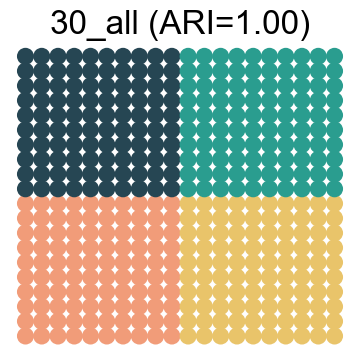

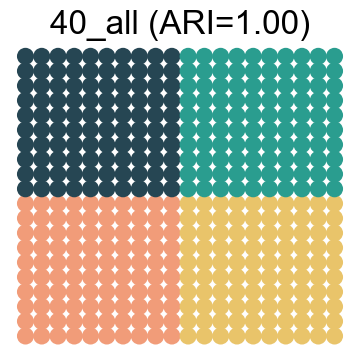

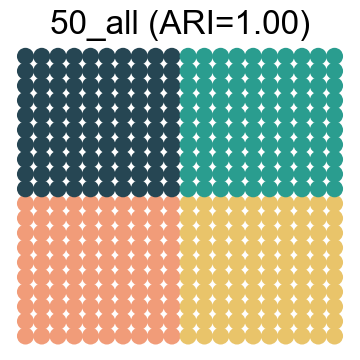

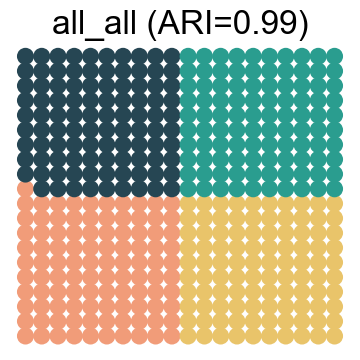

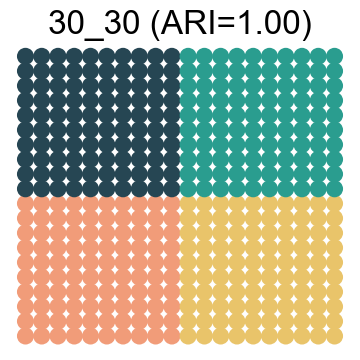

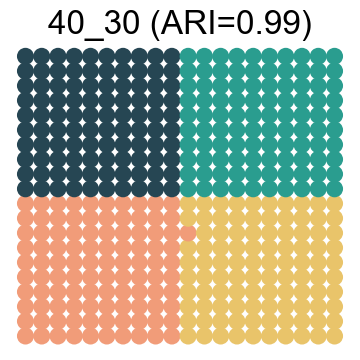

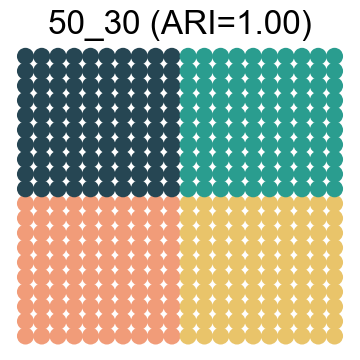

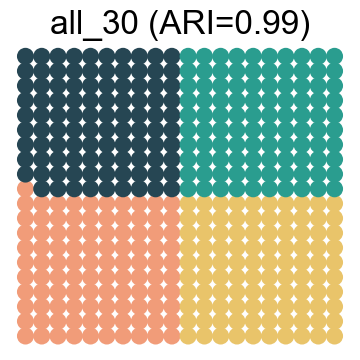

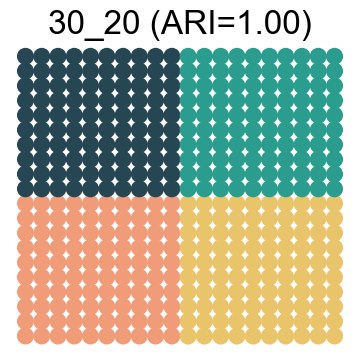

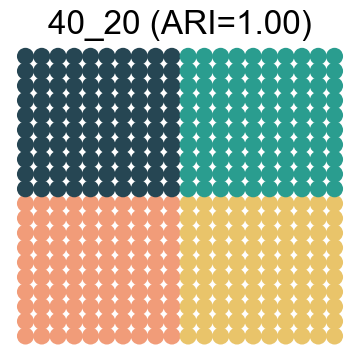

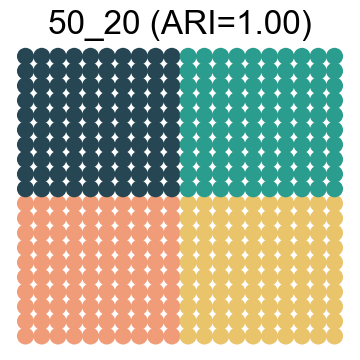

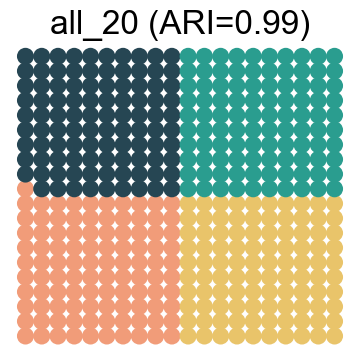

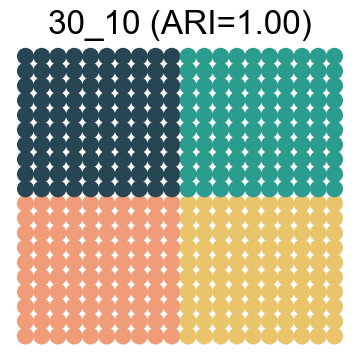

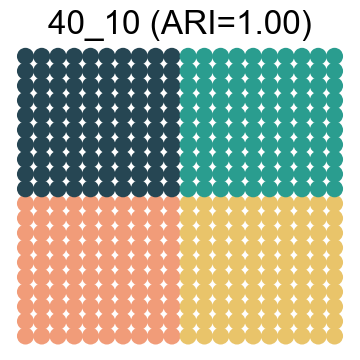

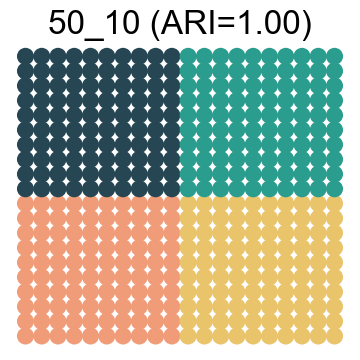

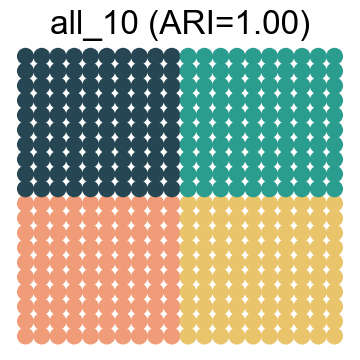

In [ ]:
colors_domain = [
    '#f19c79', '#e9c46a', '#2a9d8f', '#264653'
]

save_path = f"./Results/sensitivity analysis and ablation experiment/Spatial_Scenario/Sensitive_Analysis/"
methods = ['30_all', '40_all', '50_all', 'all_all', '30_30', '40_30', '50_30', 'all_30', '30_20', '40_20', '50_20', 'all_20', '30_10', '40_10', '50_10', 'all_10']

# Set font size and font type
plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = ['Arial']  # Ensure the font list is correctly formatted

# Iterate through each method and plot
for method in methods:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))  # Create a subplot
    # Calculate Adjusted Rand Index (ARI)
    ari_value = adjusted_rand_score(adata_analysis.obs['Ground Truth'], adata_analysis.obs[method])
    sc.pl.embedding(adata_analysis, basis='spatial', color=[method], title=None, s=600, colorbar_loc=None, show=False, ax=ax, palette=colors_domain, legend_loc=None)
    # Set title including ARI value
    ax.set_title(f"{method} (ARI={ari_value:.2f})")
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Hide the borders of the axes
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Adjust subplot parameters to reduce white space around the plot
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.tight_layout()

    plt.savefig(save_path + f"{method}.png", dpi=500)
    plt.savefig(save_path + f"{method}.eps", dpi=500)

    # Display the plot
    plt.show()